In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
import gp_lens
import numpy as np
import matplotlib.pyplot as plt
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [11]:
# (x[4], x[17], x[29])

In [4]:
peaks = gp_lens.LensingPSorPeaks(-0.8,100, 'KN', redshifts=('10_ng40',), observable_name='Peaks', bin_center_row=1)
x, y = peaks.get_realizations(model_index=1, verbose=True)
peaks.fid = np.mean(y,axis=0)

/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps10_ng40/Peaks_KN_s1.00_z1.00_ng40.00_b050.npy
[42]


In [10]:
x

array([-6.40000000e-01, -4.80000000e-01, -3.20000000e-01, -1.60000000e-01,
       -1.10213281e-16,  1.60000000e-01,  3.20000000e-01,  4.80000000e-01,
        6.40000000e-01,  8.00000000e-01,  9.60000000e-01,  1.12000000e+00,
        1.28000000e+00,  1.44000000e+00,  1.60000000e+00,  1.76000000e+00,
        1.92000000e+00,  2.08000000e+00,  2.24000000e+00,  2.40000000e+00,
        2.56000000e+00,  2.72000000e+00,  2.88000000e+00,  3.04000000e+00,
        3.20000000e+00,  3.36000000e+00,  3.52000000e+00,  3.68000000e+00,
        3.84000000e+00,  4.00000000e+00,  4.16000000e+00,  4.32000000e+00,
        4.48000000e+00,  4.64000000e+00,  4.80000000e+00,  4.96000000e+00,
        5.12000000e+00,  5.28000000e+00,  5.44000000e+00,  5.60000000e+00,
        5.76000000e+00,  5.92000000e+00])

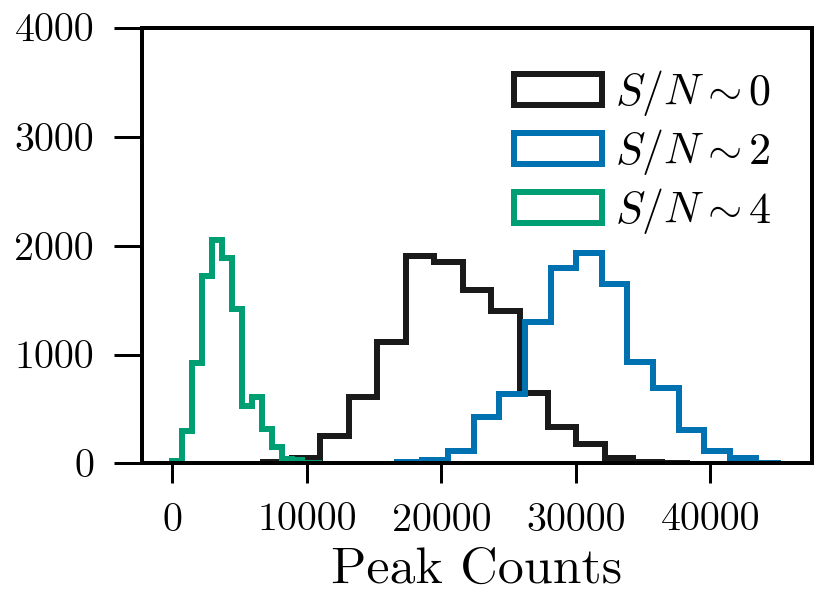

In [152]:
plt.hist( y[:,4], bins=15, histtype='step', label=r"$S/N \sim 0$" )
plt.hist( y[:,17], bins=15, histtype='step', label=r"$S/N \sim 2$" )
plt.hist( y[:,29], bins=15, histtype='step', label=r"$S/N \sim 4$" )
plt.legend()
plt.ylim(0,4000)
plt.xlabel('Peak Counts')
plt.savefig('figures/peaks_are_gaussian.pdf')

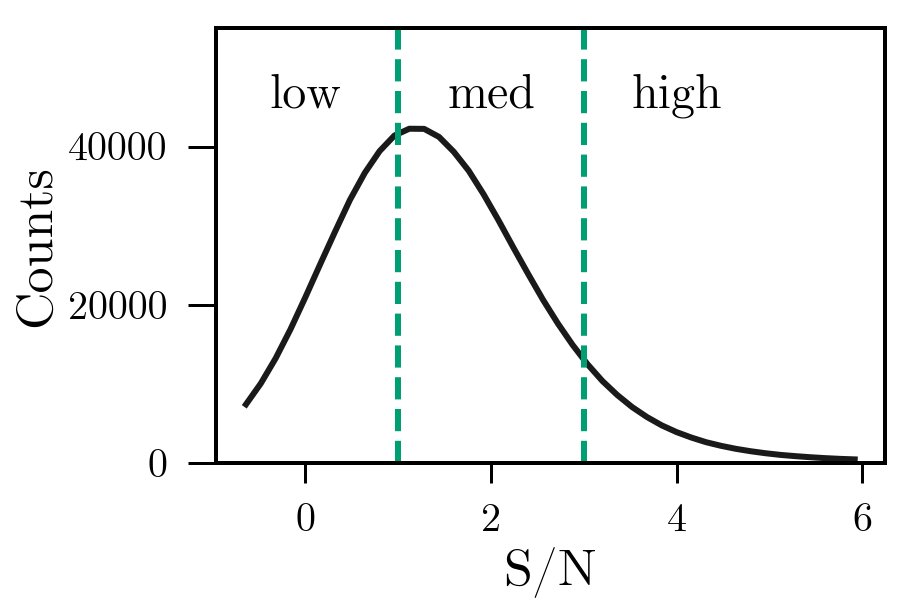

In [160]:
plt.plot(x, peaks.fid)
plt.axvline(1, ls='dashed', color=default_color_list[2])
plt.axvline(3, ls='dashed', color=default_color_list[2])

plt.text(0, 45000, "low", horizontalalignment='center', fontsize=24)
plt.text(2, 45000, "med", horizontalalignment='center', fontsize=24)
plt.text(4, 45000, "high", horizontalalignment='center', fontsize=24)

plt.ylim(0,55000)
plt.ylabel('Counts')
plt.xlabel('S/N')
plt.savefig('figures/different_SN_regions.pdf')

In [ ]:
# powerspec = LensingPSorPeaks(300,3000, 'K', redshifts=('10',), observable_name='PS', bin_center_row=0, binscale='log')
# x, y = powerspec.get_realizations(model_index=0, verbose=True)
# powerspec.fid = np.mean(y,axis=0)
# plt.plot(powerspec.fid)

In [ ]:
cov_10k = np.linalg.inv((peaks.compute_cov(0, verbose=True)))
cov_1k = np.linalg.inv((peaks.compute_cov(0, verbose=True, covariance=False, max_realizations=1000)))
plt.plot( x, np.diag(cov_10k) )
plt.plot( x, np.diag(cov_1k) )
plt.yscale("log")

In [132]:
index_list = np.arange(len(peaks.params.T))
index_list = np.delete(index_list, 0)
index_list = np.delete(index_list, 0)

modified_y = [peaks.get_realizations(i) for i in index_list]
modified_X = (peaks.params.T[index_list]).T

peaks.fit(X=modified_X, real_list=modified_y)

In [ ]:
# set up some constants for prior evaluation
m_nu_min = 0.06  # minimum from oscillation experiments
m_nu_max = 2*np.max(peaks.table['M_nu(eV)'])
om_m_min = np.min(peaks.table['Omega_m'])
om_m_max = 2*np.max(peaks.table['Omega_m'])
A_s_min = np.min(peaks.table['10^9*A_s'])
A_s_max = 2*np.max(peaks.table['10^9*A_s'])

In [ ]:

# define emcee function calls, prior, likelihood,
def lnprior(theta):
    """Ensure the sampler stays near computed simulations."""
    m_nu, om_m, A_s = theta
    if (m_nu_min < m_nu < m_nu_max and
            om_m_min < om_m < om_m_max and
            A_s_min < A_s < A_s_max):
        return 0.0
    return -np.inf


def lnlike(theta):
    """Compute the log likelihood based on multivariate Gaussian."""
    return peaks.likelihood(theta)


def lnprob(theta):
    """Combine the likelihood and prior."""
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)


In [ ]:

import emcee

# set up emcee
ndim, nwalkers = 3, 64
p0 = [peaks.params.T[1] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# begin sampling, use incremental chain
filename = 'test.out'
f = open(filename, "w")
f.close()

for result in sampler.sample(p0, iterations=5000, storechain=False):
    position = result[0]
    f = open(filename, "a")
    for k in range(position.shape[0]):
        out_str = "{0:4d} {1:s}\n".format(k, ' '.join(map(str, position[k])))
        f.write(out_str)
    f.close()


# Reconstruction Error


/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps10_ng40/Peaks_KN_s1.00_z1.00_ng40.00_b050.npy
[42]
(9999, 42)


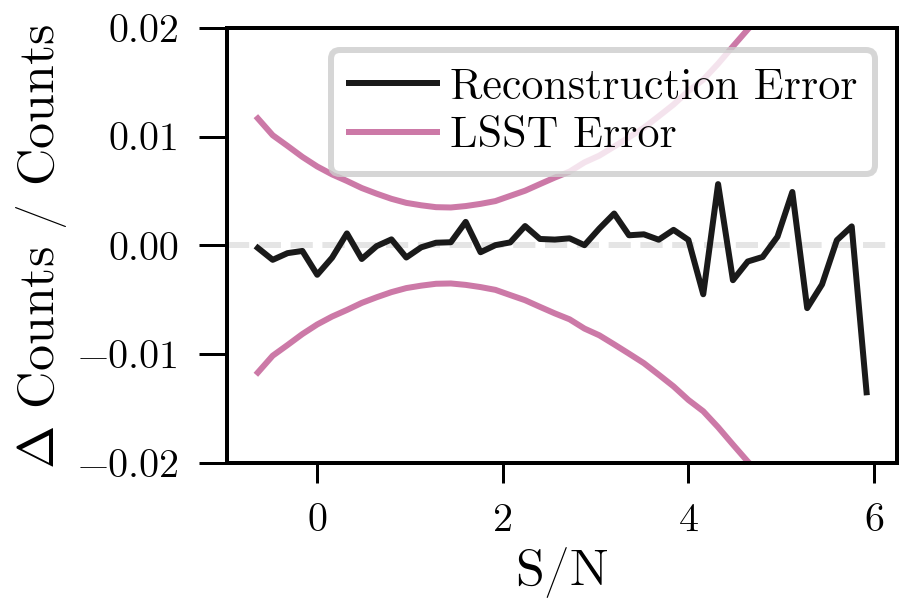

In [138]:
test_model = 1
x, y = peaks.get_realizations(model_index=1, verbose=True)
y_true = np.mean(y, axis=0)

plt.axhline(0.0, color=(0,0,0,0.1), ls='dashed')

ys, sigs = peaks.GP(peaks.params.T[1])
# plt.fill_between( x, (sigs/y_true), (-sigs/y_true), color=default_color_list[3], alpha=0.2)

# plt.plot(ys)
plt.plot( x, (ys-y_true)/y_true, '-', label="Reconstruction Error")

invcov = peaks.compute_cov(0)
cov = np.linalg.inv(invcov)
plt.plot( x, np.sqrt(np.diag(cov))/y_true, label='LSST Error', color=default_color_list[4] )
plt.plot( x, -np.sqrt(np.diag(cov))/y_true, color=default_color_list[4] )

plt.legend(frameon=True)
plt.ylim(-0.02, 0.02)

plt.ylabel(r'$\Delta$ Counts / Counts')
plt.xlabel('S/N')
plt.savefig('figures/reconstruction_peaks.pdf')

In [12]:
peaks.likelihood([0.1,0.3,2.1])

-0.7238234317929026

In [13]:
peaks2 = gp_lens.LensingPSorPeaks(-0.02, 0.06, 'K', redshifts=('10',), observable_name='Peaks', bin_center_row=0)
x, y = peaks2.get_realizations(model_index=1, verbose=True)
peaks2.fid = np.mean(y,axis=0)

index_list = np.arange(len(peaks2.params.T))
index_list = np.delete(index_list, 0)
index_list = np.delete(index_list, 0)

modified_y = [peaks2.get_realizations(i) for i in index_list]
modified_X = (peaks2.params.T[index_list]).T

peaks2.fit(X=modified_X, real_list=modified_y)

/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps10/Peaks_K_s1.00_z1.00_ng13.25_b050.npy


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.37626106e-05, -7.77552187e-04,  4.11245736e-03, -6.65827317e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 26, 'warnflag': 2}
  " state: %s" % convergence_dict)
